# **SparkML Heart Risk Classifier**

## **Libraries**

In [1]:
!pip install pyspark -q
!pip install pandas seaborn matplotlib -q

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, Imputer, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, create_map, lit
from itertools import chain

## **Spark Session**

In [3]:
spark = SparkSession.builder.appName("FinalHeartClassifier").getOrCreate()

## **Loading Dataset**

In [4]:
try:
    data = spark.read.csv("heart_disease_uci.csv", header=True, inferSchema=True)
    print(f"Dataset loaded successfully. Total number of rows: {data.count()}")
except Exception as e:
    print(f"Error loading file: {e}")
    print("Please make sure the file 'heart_disease_uci.csv' is available.")
    # If there is an error, do not continue the code.
    spark.stop()

Dataset loaded successfully. Total number of rows: 920


## **Preprocessing and Feature Engineering**

In [5]:
# Removing unnecessary columns that are not used in modeling
data = data.drop("id", "dataset")

# Fix data type error: Convert Boolean columns to Integer so they can be used in Imputer
data = data.withColumn("fbs", col("fbs").cast("integer"))
data = data.withColumn("exang", col("exang").cast("integer"))
print("\nSchema after converting Boolean columns (fbs, exang):")
data.printSchema()

# Dealing with data imbalance: calculating and adding a weight column for each class
# This helps the model give more importance to classes with fewer examples.
class_counts = data.groupBy("num").count().orderBy("num").collect()
total_samples = data.count()
num_classes = len(class_counts)
weights = {row['num']: total_samples / (num_classes * row['count']) for row in class_counts}
print(f"\nCalculated weights for each class (to deal with imbalance)): {weights}")

# Adding a weight column to a dataframe
mapping_expr = create_map([lit(x) for x in chain(*weights.items())])
data = data.withColumn("classWeight", mapping_expr.getItem(col("num")))


Schema after converting Boolean columns (fbs, exang):
root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- cp: string (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: string (nullable = true)
 |-- thalch: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: string (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: string (nullable = true)
 |-- num: integer (nullable = true)


Calculated weights for each class (to deal with imbalance)): {0: 0.44768856447688565, 1: 0.6943396226415094, 2: 1.688073394495413, 3: 1.719626168224299, 4: 6.571428571428571}


/usr/local/lib/python3.11/dist-packages/pyspark/sql/column.py:460: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  warnings.warn(


## **Pipeline Construction and Model Definition**

In [6]:
# Defining numeric and categorical columns
categorical_cols = ['sex', 'cp', 'restecg', 'slope', 'thal']
numerical_cols = ['age', 'trestbps', 'chol', 'fbs', 'thalch', 'exang', 'oldpeak', 'ca']

# Step 1: Imputer to fill in missing numeric values with the mean (instead of deleting rows)
imputer = Imputer(inputCols=numerical_cols, outputCols=[c + "_imputed" for c in numerical_cols], strategy="mean")

# Step 2: StringIndexer to convert text columns to numeric
indexers = [StringIndexer(inputCol=c, outputCol=c + "_indexed", handleInvalid="keep") for c in categorical_cols]

# Step 3: StringIndexer for target column (convert 'num' to 'label')
label_indexer = StringIndexer(inputCol="num", outputCol="label")

# Step 4: VectorAssembler to assemble all features into a single vector
assembler_inputs = [c + "_imputed" for c in numerical_cols] + [c + "_indexed" for c in categorical_cols]
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

# step 5: StandardScaler for feature scaling (improve model performance)
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# Step 6: Define the RandomForest classification model
rf = RandomForestClassifier(
    labelCol="label",
    featuresCol="scaledFeatures",
    weightCol="classWeight",  # Using a weight column for training
    numTrees=100,
    maxDepth=10,
    seed=42
)

# Connecting all stages together in a single pipeline
pipeline = Pipeline(stages=[imputer] + indexers + [label_indexer, assembler, scaler, rf])

## **Train / Test Split and Fit**

In [7]:
# 7. Split the data into training and testing sets and then train the model
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Check the number of data in each set to ensure there are no problems.
print(f"\nNumber of rows in the training data: {train_data.count()}")
print(f"Number of rows in test data: {test_data.count()}")

print("\nStarting to train the model... (This step may take some time.))")
pipeline_model = pipeline.fit(train_data)
print("Model training is complete.")


Number of rows in the training data: 771
Number of rows in test data: 149

Starting to train the model... (This step may take some time.))
Model training is complete.


## **Model Evaluation and Confusion Matrix Plotting**


--- Model evaluation results ---
F1 Score (The main criterion for unbalanced data): 0.5140
Accuracy: 0.5503

Constructing a clutter matrix...


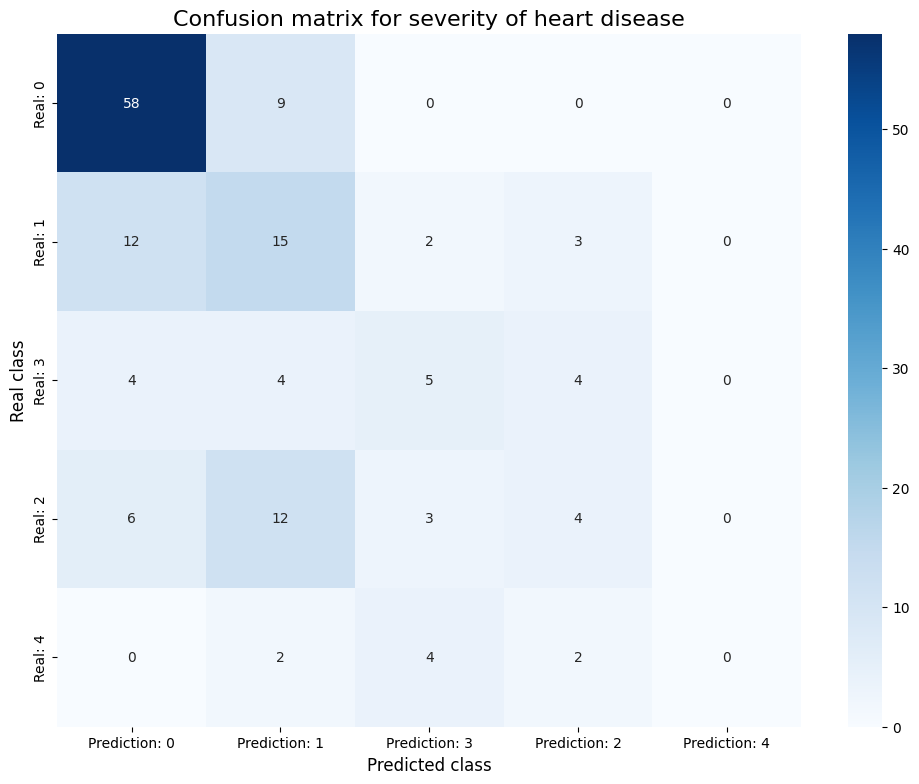

In [8]:
# 8. Evaluate the model and plot the confusion matrix
# Make predictions on test data
# Make predictions on test data
predictions = pipeline_model.transform(test_data)

# Calculating evaluation criteria
print("\n--- Model evaluation results ---")
f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1").evaluate(predictions)
accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy").evaluate(predictions)
print(f"F1 Score (The main criterion for unbalanced data): {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Preparing to draw the clutter matrix
print("\nConstructing a clutter matrix...")
preds_and_labels = predictions.select("prediction", "label").toPandas()

if preds_and_labels.empty:
    print("Error: No data to evaluate! The problem is in the previous steps.")
else:
    # ★★★ Key fix here ★★★
    # Accessing the correct stage in the Pipeline:
    # Order of final stages: [... -> label_indexer -> assembler -> scaler -> model]
    # So label_indexer is the fourth stage from the end (index -4)
    label_converter = pipeline_model.stages[-4]
    original_labels = label_converter.labels

    # Creating matrices with Pandas
    confusion_matrix_df = pd.crosstab(preds_and_labels['label'], preds_and_labels['prediction'])

    # Make sure all classes are in the matrix and sort them
    # This will prevent the graph from collapsing if a class is missing from the test data
    all_indices = list(range(len(original_labels)))
    confusion_matrix_df = confusion_matrix_df.reindex(index=all_indices, columns=all_indices, fill_value=0)

    # Rename rows and columns to original labels for better readability
    tick_labels = [original_labels[i] for i in confusion_matrix_df.index]
    confusion_matrix_df.index = [f"Real: {l}" for l in tick_labels]
    confusion_matrix_df.columns = [f"Prediction: {l}" for l in tick_labels]

    # Matrix drawing
    plt.figure(figsize=(12, 9))
    sns.heatmap(confusion_matrix_df, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion matrix for severity of heart disease', fontsize=16)
    plt.ylabel('Real class', fontsize=12)
    plt.xlabel('Predicted class', fontsize=12)
    plt.show()

## **Spark Session Stop**

In [9]:
# 9. Stopping a Spark Session to Free Resources
spark.stop()
print("\nSpark Session It stopped.")


Spark Session It stopped.


## **THE END**